In [1]:
import pandas as pd
import os, sys
import numpy as np

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))
from utils.prediction_utils import *

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)


In [2]:
# Load your data using the get_data function
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling"
X, y = get_data("conv2d", base_dir, sample_rate=1.0)

# Combine X and y into a single DataFrame for convenience
df = pd.concat([X, y], axis=1)
df = df.query("time > 0").dropna()
X, y = df.drop(columns=["time"]), df["time"]

# Ensure dtype columns are of integer type
X = X.astype({"dtype_16": int, "dtype_32": int, "dtype_b16": int})

34it [00:18,  1.15it/s]

< 0 found in file time.32.1024.0.pkl


44it [00:26,  1.17it/s]

< 0 found in file time.128.512.0.pkl


46it [00:28,  1.11it/s]

< 0 found in file time.128.1024.0.pkl


54it [00:34,  1.29it/s]

< 0 found in file time.512.128.0.pkl


56it [00:37,  1.17it/s]

< 0 found in file time.512.512.0.pkl


58it [00:39,  1.11it/s]

< 0 found in file time.512.1024.0.pkl


59it [00:40,  1.13s/it]

< 0 found in file time.512.1024.1.pkl


64it [00:43,  1.50it/s]

< 0 found in file time.1024.32.0.pkl


66it [00:45,  1.28it/s]

< 0 found in file time.1024.128.0.pkl


68it [00:47,  1.17it/s]

< 0 found in file time.1024.512.0.pkl


69it [00:49,  1.07s/it]

< 0 found in file time.1024.512.1.pkl


70it [00:49,  1.11it/s]

< 0 found in file time.1024.1024.0.pkl


71it [00:51,  1.12s/it]

< 0 found in file time.1024.1024.1.pkl


72it [00:51,  1.39it/s]
/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/utils/time_utils.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(dfs, axis=0, ignore_index=True)


In [ ]:
decay_param = 0.93
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_array = X_scaled  # Use scaled features
y_array = y.values  # Target variable as numpy array

# Use roofline model

Epoch [1/20], Training Loss: 244362.9625, Validation Loss: 249649.3416
Min predicted_alpha: 0.009999999776482582, Max predicted_alpha: 0.5288382768630981
Epoch [2/20], Training Loss: 264880.7922, Validation Loss: 280792.1449
Min predicted_alpha: 0.009999999776482582, Max predicted_alpha: 0.5288382768630981
Epoch [3/20], Training Loss: 275795.9453, Validation Loss: 280799.8370
Min predicted_alpha: 0.009999999776482582, Max predicted_alpha: 0.5288382768630981
Epoch [4/20], Training Loss: 275701.4295, Validation Loss: 280918.3375
Min predicted_alpha: 0.009999999776482582, Max predicted_alpha: 0.5288382768630981
Epoch [5/20], Training Loss: 275636.6505, Validation Loss: 281054.6212
Min predicted_alpha: 0.009999999776482582, Max predicted_alpha: 0.5288382768630981
Epoch [6/20], Training Loss: 275596.1518, Validation Loss: 280761.9648
Min predicted_alpha: 0.009999999776482582, Max predicted_alpha: 0.5288382768630981
Epoch [7/20], Training Loss: 275620.0580, Validation Loss: 280900.8477
Min p

/var/folders/c8/q9xddvxj5pv262qffnm05sk00000gn/T/ipykernel_66573/3419124375.py:466: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_mode

Final Validation Loss: 249649.3416


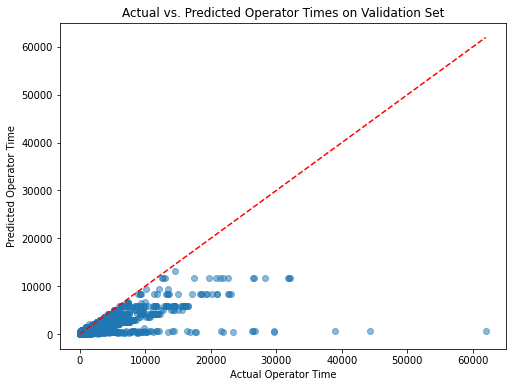

In [4]:
def get_dtype_bytes(row):
    if row["dtype_32"]:
        return 4
    elif row["dtype_16"]:
        return 2
    elif row["dtype_b16"]:
        return 2
    else:
        raise ValueError("Unknown dtype in row.")

padding = 0
output_padding = 0

# Note: this is a heuristic.
input_memory_accesses = df["b"] * df["in_channels"] * df["iH"] * df["iW"]
kernel_memory_accesses = (
    df["out_channels"] * (df["in_channels"] // df["groups"]) * df["kH"] * df["kW"]
)
output_memory_accesses = df["b"] * df["out_channels"] * df["oH"] * df["oW"]
memory_accesses = (
    (input_memory_accesses + kernel_memory_accesses + output_memory_accesses)
    * df.apply(get_dtype_bytes, axis=1)
    / 1e9
)  # in GB

intensity = df["gflops"] / memory_accesses

# Convert to numpy arrays
memory_accesses_array = memory_accesses.values  # NumPy array
intensity_array = intensity.values  # NumPy array


def get_dtype_peak_fp(row):
    if row["dtype_32"]:
        return 156
    elif row["dtype_16"]:
        return 312
    elif row["dtype_b16"]:
        return 312
    else:
        raise ValueError("Unknown dtype in row.")


# Compute pi for the entire dataset
pi_array = df.apply(get_dtype_peak_fp, axis=1).values  # in GFLOPs

# Define beta (DRAM bandwidth in GB/ms)
beta = 2.03904

# Split data into training and validation sets, including additional features
(
    X_train,
    X_val,
    y_train,
    y_val,
    memory_accesses_train,
    memory_accesses_val,
    intensity_train,
    intensity_val,
    pi_train,
    pi_val,
) = train_test_split(
    X_array,
    y_array,
    memory_accesses_array,
    intensity_array,
    pi_array,
    test_size=0.2,
    random_state=random_seed,
)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

memory_accesses_train_tensor = torch.tensor(memory_accesses_train, dtype=torch.float32)
memory_accesses_val_tensor = torch.tensor(memory_accesses_val, dtype=torch.float32)

intensity_train_tensor = torch.tensor(intensity_train, dtype=torch.float32)
intensity_val_tensor = torch.tensor(intensity_val, dtype=torch.float32)

pi_train_tensor = torch.tensor(pi_train, dtype=torch.float32)
pi_val_tensor = torch.tensor(pi_val, dtype=torch.float32)

# Create TensorDatasets for training and validation sets
train_dataset = TensorDataset(
    X_train_tensor,
    y_train_tensor,
    memory_accesses_train_tensor,
    intensity_train_tensor,
    pi_train_tensor,
)
val_dataset = TensorDataset(
    X_val_tensor,
    y_val_tensor,
    memory_accesses_val_tensor,
    intensity_val_tensor,
    pi_val_tensor,
)

# Define batch size
batch_size = 1024

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


def weighted_mse_loss(y_true, y_pred, weight):
    loss = weight * (y_true - y_pred) ** 2
    return loss.mean()


def mape_loss(y_true, y_pred):
    epsilon = 1e-8  # to prevent division by zero
    loss = torch.abs(
        (y_true - y_pred) / (y_true + epsilon)
    )  # Add epsilon for stability
    return torch.mean(loss)


# Define the custom loss function
def custom_loss_function(
    predicted_alpha,
    target_operator_time,
    batch_memory_accesses,
    batch_intensity,
    batch_pi,
    beta,
):
    """
    predicted_alpha: Output from the neural network (predicted alpha)
    target_operator_time: Actual operator times (ground truth)
    batch_memory_accesses: Memory accesses for the batch
    batch_intensity: Arithmetic intensity for the batch
    batch_pi: Peak FLOPs/sec for the batch
    beta: Predefined DRAM bandwidth
    """

    batch_total_flops = batch_intensity * batch_memory_accesses  # GFLOPs
    predicted_alpha = predicted_alpha.clamp(min=1e-6)
    estimated_operator_time = torch.max(
        batch_total_flops / (batch_pi * decay_param),
        batch_memory_accesses / (predicted_alpha * beta),
    )

    # weights = 1 + target_operator_time / max(target_operator_time)  # Higher weights for larger operator times
    # loss = weighted_mse_loss(target_operator_time, estimated_operator_time, weights)

    # log_target_operator_time = torch.log1p(target_operator_time)
    # loss = torch.nn.functional.mse_loss(torch.log1p(estimated_operator_time), log_target_operator_time)

    # loss = mape_loss(target_operator_time, estimated_operator_time)
    loss = torch.nn.functional.mse_loss(estimated_operator_time, target_operator_time)
    return loss


# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_p=0.2):
        super(Net, self).__init__()
        layers = []
        in_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout_p))  # Add Dropout layer
            in_size = hidden_size

        layers.append(nn.Linear(in_size, output_size))
        layers.append(nn.Sigmoid())  # Ensure output is between 0 and 1
        # layers.append(nn.ReLU())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x).clamp(min=1e-2)


# Define model parameters
input_size = X_train_tensor.shape[1]
hidden_sizes = [256, 128, 64, 64, 32]
output_size = 1  # Predicting alpha

# Initialize the model
model = Net(input_size, hidden_sizes, output_size, dropout_p=0.0)

# Define optimizer without weight decay
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.0005, weight_decay=0.0001
)  # No weight_decay

# Number of epochs
num_epochs = 20

# For early stopping
patience = 10
best_val_loss = float("inf")
epochs_no_improve = 0

# Training loop with validation
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # min_predicted_alpha = float("inf")
    # max_predicted_alpha = float("-inf")

    for (
        batch_X,
        batch_y,
        batch_memory_accesses,
        batch_intensity,
        batch_pi,
    ) in train_loader:
        # Forward pass: predict alpha
        predicted_alpha = model(batch_X).squeeze()  # .squeeze() to align shapes
        min_predicted_alpha = min(min_predicted_alpha, predicted_alpha.min().item())
        max_predicted_alpha = max(max_predicted_alpha, predicted_alpha.max().item())

        # Compute loss
        loss = custom_loss_function(
            predicted_alpha,
            batch_y,
            batch_memory_accesses,
            batch_intensity,
            batch_pi,
            beta,
        )

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Average training loss
    avg_train_loss = train_loss / len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (
            batch_X_val,
            batch_y_val,
            batch_memory_accesses_val,
            batch_intensity_val,
            batch_pi_val,
        ) in val_loader:
            # Forward pass
            predicted_alpha_val = model(batch_X_val).squeeze()

            # Compute loss
            loss_val = custom_loss_function(
                predicted_alpha_val,
                batch_y_val,
                batch_memory_accesses_val,
                batch_intensity_val,
                batch_pi_val,
                beta,
            )

            val_loss += loss_val.item()

    # Average validation loss
    avg_val_loss = val_loss / len(val_loader)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}"
    )
    print(
        f"Min predicted_alpha: {min_predicted_alpha}, Max predicted_alpha: {max_predicted_alpha}"
    )

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pt")  # Save the best model
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping!")
        break

# Load the best model
model.load_state_dict(torch.load("best_model.pt"))

# Evaluate on validation set
model.eval()
val_loss = 0.0
with torch.no_grad():
    for (
        batch_X_val,
        batch_y_val,
        batch_memory_accesses_val,
        batch_intensity_val,
        batch_pi_val,
    ) in val_loader:
        # Forward pass
        predicted_alpha_val = model(batch_X_val).squeeze()

        # Compute loss
        loss_val = custom_loss_function(
            predicted_alpha_val,
            batch_y_val,
            batch_memory_accesses_val,
            batch_intensity_val,
            batch_pi_val,
            beta,
        )

        val_loss += loss_val.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Final Validation Loss: {avg_val_loss:.4f}")

# Get predictions and actual values for the validation set
all_predicted_times = []
all_actual_times = []
with torch.no_grad():

    for (
        batch_X_val,
        batch_y_val,
        batch_memory_accesses_val,
        batch_intensity_val,
        batch_pi_val,
    ) in val_loader:
        # Forward pass: Predict alpha
        predicted_alpha_val = model(batch_X_val).squeeze()

        # Compute total FLOPs for this batch
        batch_total_flops_val = (
            batch_intensity_val * batch_memory_accesses_val
        )  # GFLOPs

        # Ensure no zero values for predicted alpha
        predicted_alpha_val = predicted_alpha_val.clamp(min=1e-6)

        # Calculate estimated operator time
        estimated_operator_time_val = torch.max(
            batch_total_flops_val / (batch_pi_val * 0.95),
            batch_memory_accesses_val / (predicted_alpha_val * beta),
        )

        # Inverse log transformation to get the original scale
        # estimated_operator_time_val = torch.expm1(estimated_operator_time_val)

        # Store predictions and actual values
        all_predicted_times.append(estimated_operator_time_val.numpy())
        all_actual_times.append(batch_y_val.numpy())

# Concatenate all batches
all_predicted_times = np.concatenate(all_predicted_times)
all_actual_times = np.concatenate(all_actual_times)

# Plot actual vs. predicted operator times
plt.figure(figsize=(8, 6))
plt.scatter(all_actual_times, all_predicted_times, alpha=0.5)
plt.xlabel("Actual Operator Time")
plt.ylabel("Predicted Operator Time")
plt.title("Actual vs. Predicted Operator Times on Validation Set")
plt.plot(
    [all_actual_times.min(), all_actual_times.max()],
    [all_actual_times.min(), all_actual_times.max()],
    "r--",
)
plt.show()

# Predict runtime directly

Epoch [1/20], Training Loss: 4.0058, Validation Loss: 3.7969
Epoch [2/20], Training Loss: 3.7640, Validation Loss: 3.7911
Epoch [3/20], Training Loss: 3.7648, Validation Loss: 3.7952
Epoch [4/20], Training Loss: 3.7648, Validation Loss: 3.7925
Epoch [5/20], Training Loss: 3.7652, Validation Loss: 3.7923
Epoch [6/20], Training Loss: 3.7646, Validation Loss: 3.7952
Epoch [7/20], Training Loss: 3.7644, Validation Loss: 3.7956
Epoch [8/20], Training Loss: 3.7651, Validation Loss: 3.7932
Epoch [9/20], Training Loss: 3.7651, Validation Loss: 3.7973
Epoch [10/20], Training Loss: 3.7637, Validation Loss: 3.7912
Epoch [11/20], Training Loss: 3.7651, Validation Loss: 3.7926
Epoch [12/20], Training Loss: 3.7642, Validation Loss: 3.7933
Early stopping!


/var/folders/c8/q9xddvxj5pv262qffnm05sk00000gn/T/ipykernel_66573/327155908.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model

Final Validation Loss: 529587.5494


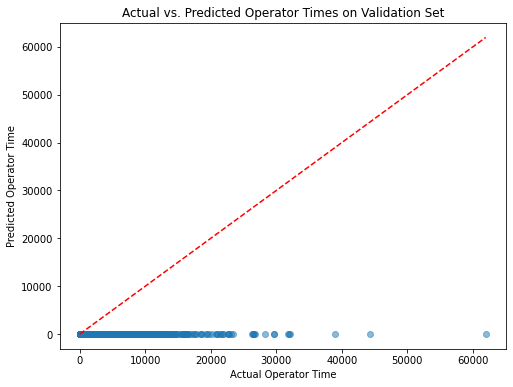

In [9]:
# Apply log transformation to target (operator times)
y_array_log = np.log1p(y_array)  # log(1 + y) to avoid issues with zero values

# Split data into training and validation sets, including additional features
(
    X_train,
    X_val,
    y_train,
    y_val,
    memory_accesses_train,
    memory_accesses_val,
    intensity_train,
    intensity_val,
    pi_train,
    pi_val,
) = train_test_split(
    X_array,
    y_array_log,  # Use log-transformed targets
    memory_accesses_array,
    intensity_array,
    pi_array,
    test_size=0.2,
    random_state=random_seed,
)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

memory_accesses_train_tensor = torch.tensor(memory_accesses_train, dtype=torch.float32)
memory_accesses_val_tensor = torch.tensor(memory_accesses_val, dtype=torch.float32)

intensity_train_tensor = torch.tensor(intensity_train, dtype=torch.float32)
intensity_val_tensor = torch.tensor(intensity_val, dtype=torch.float32)

pi_train_tensor = torch.tensor(pi_train, dtype=torch.float32)
pi_val_tensor = torch.tensor(pi_val, dtype=torch.float32)

# Create TensorDatasets for training and validation sets
train_dataset = TensorDataset(
    X_train_tensor,
    y_train_tensor,
    memory_accesses_train_tensor,
    intensity_train_tensor,
    pi_train_tensor,
)
val_dataset = TensorDataset(
    X_val_tensor,
    y_val_tensor,
    memory_accesses_val_tensor,
    intensity_val_tensor,
    pi_val_tensor,
)

# Define batch size
batch_size = 1024

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_p=0.2):
        super(Net, self).__init__()
        layers = []
        in_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout_p))  # Add Dropout layer
            in_size = hidden_size

        layers.append(nn.Linear(in_size, output_size))
        # No activation in the final layer because we are predicting continuous values
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Define model parameters
input_size = X_train_tensor.shape[1]
hidden_sizes = [256, 128, 64, 64, 32]
output_size = 1  # Predicting log-transformed operator times

# Initialize the model
model = Net(input_size, hidden_sizes, output_size, dropout_p=0.0)

# Define optimizer without weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.0001)

# Number of epochs
num_epochs = 20

# For early stopping
patience = 10
best_val_loss = float("inf")
epochs_no_improve = 0

# Training loop with validation
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch_X, batch_y, _, _, _ in train_loader:
        # Forward pass: predict log-transformed operator times
        predicted_time_log = model(batch_X).squeeze()

        # Compute loss using standard MSE
        loss = torch.nn.functional.mse_loss(predicted_time_log, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Average training loss
    avg_train_loss = train_loss / len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X_val, batch_y_val, _, _, _ in val_loader:
            # Forward pass: predict log-transformed operator times
            predicted_time_log_val = model(batch_X_val).squeeze()

            # Compute validation loss using standard MSE
            loss_val = torch.nn.functional.mse_loss(predicted_time_log_val, batch_y_val)

            val_loss += loss_val.item()

    # Average validation loss
    avg_val_loss = val_loss / len(val_loader)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}"
    )

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pt")  # Save the best model
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping!")
        break

# Load the best model
model.load_state_dict(torch.load("best_model.pt"))

# Evaluate on validation set
model.eval()
val_loss = 0.0
all_predicted_times = []
all_actual_times = []
with torch.no_grad():
    for batch_X_val, batch_y_val, _, _, _ in val_loader:
        # Forward pass: predict log-transformed operator times
        predicted_time_log_val = model(batch_X_val).squeeze()

        # Apply inverse log transformation to get back the original operator times
        predicted_time_val = torch.expm1(predicted_time_log_val)

        val_loss += torch.nn.functional.mse_loss(predicted_time_val, torch.expm1(batch_y_val)).item()

        # Store predictions and actual values
        all_predicted_times.append(predicted_time_val.numpy())
        all_actual_times.append(torch.expm1(batch_y_val).numpy())  # Convert log target to original scale

    avg_val_loss = val_loss / len(val_loader)
    print(f"Final Validation Loss: {avg_val_loss:.4f}")

# Concatenate all batches
all_predicted_times = np.concatenate(all_predicted_times)
all_actual_times = np.concatenate(all_actual_times)

# Plot actual vs. predicted operator times
plt.figure(figsize=(8, 6))
plt.scatter(all_actual_times, all_predicted_times, alpha=0.5)
plt.xlabel("Actual Operator Time")
plt.ylabel("Predicted Operator Time")
plt.title("Actual vs. Predicted Operator Times on Validation Set")
plt.plot(
    [all_actual_times.min(), all_actual_times.max()],
    [all_actual_times.min(), all_actual_times.max()],
    "r--",
)
plt.show()


# Neural Network Training

## From Paper

In [41]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

class PredictionNetwork(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(PredictionNetwork, self).__init__()
        layers = []
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        layers.append(nn.Dropout(p=0.5))  # Dropout before the output layer
        layers.append(nn.Linear(hidden_layers[-1], output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [42]:
def rmsle_loss(y_pred, y_actual):
    return torch.sqrt(torch.mean(torch.square(torch.log1p(y_pred) - torch.log1p(y_actual))))

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=300):
    criterion = rmsle_loss
    optimizer = Adam(model.parameters(), lr=0.1, weight_decay=1e-5)  # L2 regularization
    scheduler = StepLR(optimizer, step_size=40, gamma=0.5)  # Learning rate decay

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for data, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        scheduler.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader)}')

        # Optionally validate the model
        model.eval()
        with torch.no_grad():
            validation_loss = 0
            for data, targets in val_loader:
                outputs = model(data)
                loss = criterion(outputs, targets)
                validation_loss += loss.item()
            print(f'Validation Loss: {validation_loss / len(val_loader)}')

In [ ]:
# Define your data loaders
# train_loader, val_loader = setup_data_loaders()

# Assuming a certain input size and output size
model = PredictionNetwork(input_size=10, hidden_layers=[64, 128], output_size=1)
# train_model(model, train_loader, val_loader)


## Random Stuff

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [14]:
# X_train_scaled.shape
# X_val_scaled.shape
# X_test_scaled.shape

(95155,)

In [8]:
try:
    X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_t = torch.tensor(y_train.values, dtype=torch.float32)
    X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_t = torch.tensor(y_val.values, dtype=torch.float32)
except Exception as e:
    print(f"Error occurred: {e}")

In [14]:
# Creating datasets
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [36]:
# Define the Neural Network Architecture
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(X_train_t.shape[1], 20)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class EnhancedRegressionNN(nn.Module):
    def __init__(self):
        super(EnhancedRegressionNN, self).__init__()
        self.fc1 = nn.Linear(X_train_t.shape[1], 100)  # Increase the number of neurons
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 20)
        self.fc4 = nn.Linear(20, 10)
        self.fc5 = nn.Linear(10, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)  # Adding dropout for regularization

        # Optional: Include batch normalization layers
        self.batch_norm1 = nn.BatchNorm1d(100)
        self.batch_norm2 = nn.BatchNorm1d(50)
        self.batch_norm3 = nn.BatchNorm1d(20)
        self.batch_norm4 = nn.BatchNorm1d(10)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)  # Applying dropout
        x = self.relu(self.batch_norm2(self.fc2(x)))
        x = self.relu(self.batch_norm3(self.fc3(x)))
        x = self.relu(self.batch_norm4(self.fc4(x)))
        x = self.fc5(x)  # Output layer without
        return x

In [39]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 634369 entries, 0 to 684936
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   b             634369 non-null  int64  
 1   in_channels   634369 non-null  int64  
 2   iH            634369 non-null  int64  
 3   iW            634369 non-null  int64  
 4   out_channels  634369 non-null  int64  
 5   groups        634369 non-null  int64  
 6   kH            634369 non-null  int64  
 7   kW            634369 non-null  int64  
 8   stride        634369 non-null  int64  
 9   dilation      634369 non-null  int64  
 10  gflops        634369 non-null  float64
 11  dtype_16      634369 non-null  bool   
 12  dtype_32      634369 non-null  bool   
 13  dtype_b16     634369 non-null  bool   
 14  transposed_0  634369 non-null  bool   
 15  transposed_1  634369 non-null  bool   
dtypes: bool(5), float64(1), int64(10)
memory usage: 61.1 MB


In [38]:
"""
TODO: write a script that
1) Takes a set of learning rates
2) Takes a potential model name
3) outputs a bunch of validation losses in a new folder.
"""
lr = 1e-4

# Instantiate the model, loss function, and optimizer
model = EnhancedRegressionNN()
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

validation_losses = []

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()
        
        train_loss = loss.item()
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, targets.view(-1, 1)).item()
        val_loss /= len(val_loader)
    validation_losses.append(val_loss)
    # if (epoch + 1) % 2 == 0:
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch 1, Train Loss: 694344.6250, Validation Loss: 500541.3714
Epoch 2, Train Loss: 350.9424, Validation Loss: 493101.3078
Epoch 3, Train Loss: 95348.5391, Validation Loss: 482951.1448
Epoch 4, Train Loss: 155022.1875, Validation Loss: 474194.9193
Epoch 5, Train Loss: 734.2679, Validation Loss: 457000.2978
Epoch 6, Train Loss: 17726.1074, Validation Loss: 418684.1120
Epoch 7, Train Loss: 1518.5846, Validation Loss: 397694.7514
Epoch 8, Train Loss: 7547.5752, Validation Loss: 390082.7111
Epoch 9, Train Loss: 4378.8276, Validation Loss: 360240.3024
Epoch 10, Train Loss: 6034.9473, Validation Loss: 315839.8117


KeyboardInterrupt: 

In [35]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 7.3877e-01,  3.1969e-01,  5.8624e-01,  6.3714e-01,  3.1101e-02,
         -3.1253e+00,  2.5411e-01,  4.2812e-01,  2.1393e-37,  2.2994e-37,
          7.5621e-03, -5.7961e-01,  1.4561e+00, -1.4630e+00,  1.1861e-01,
         -1.2178e-01],
        [ 9.1689e-01,  9.7033e-01,  7.0651e-01,  1.0657e+00,  1.9568e-01,
         -1.5035e+00,  5.1491e-01,  4.2059e-01,  1.7083e-37,  2.7001e-37,
          1.4968e-02, -2.9886e-01,  1.8517e+00, -1.8406e+00, -5.3701e-01,
          8.5764e-01],
        [ 3.8090e-03,  5.0351e-03,  2.1848e-03,  2.4860e-03,  4.2933e-03,
         -2.7401e+00,  2.3639e-03, -8.9123e-04,  2.0427e-37, -4.2463e-38,
          4.2975e-01,  1.4509e-01,  1.4507e-01,  1.4317e-01,  3.5634e-02,
          3.7120e-02],
        [ 6.2758e-01,  6.8996e-01,  8.1576e-01,  7.0331e-01,  8.7013e-02,
         -8.9521e-01,  2.6054e-01,  2.2520e-01,  5.6746e-37, -2.0159e-37,
          4.3432e-01, -2.3801e-01,  9.1401e-01, -1.2021e+00, -7.4300e-01,
          4.3373e-01]